# Predictive Analytics

### Predicting future bikesharing demand

Accurately predicting future demand is an important step towards providing a high service level (e.g. by deploying additional bikes or by re-positioning vehicles etc.)

Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in forecasting total system-level demand in the next hour. To do so, develop a prediction model that predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data). <br>
– Feature Engineering: Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features. <br>
– Model Building: Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks. <br>
– Model Evaluation: How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment? <br>
– Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project. <br>

## Feature Engineering

Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

In [1]:
#Imports
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.pipeline import Pipeline

In [2]:
#Import Dataset 
file_path = "./data/"

raw_data = pd.read_csv(f"{file_path}chicago_2017_prepared.csv")
raw_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,start_day,start_month,start_weekday,max_temp,min_temp,precip,start_lat,start_long,end_lat,end_long
0,2017-01-01 00:00:36,2017-01-01 00:06:32,414,191,Canal St & Taylor St,Canal St & Monroe St (*),2511,Customer,0,1,1,6,-0.6,-0.6,0.0,41.870257,-87.639474,41.880884,-87.639525
1,2017-01-01 00:02:54,2017-01-01 00:08:21,28,20,Larrabee St & Menomonee St,Sheffield Ave & Kingsbury St,3660,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.914680,-87.643320,41.910522,-87.653106
2,2017-01-01 00:06:06,2017-01-01 00:18:31,620,333,Orleans St & Chestnut St (NEXT Apts),Ashland Ave & Blackhawk St,4992,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.898203,-87.637536,41.907066,-87.667252
3,2017-01-01 00:07:28,2017-01-01 00:12:51,287,68,Franklin St & Monroe St,Clinton St & Tilden St,5637,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.880317,-87.635185,41.875885,-87.640795
4,2017-01-01 00:07:57,2017-01-01 00:20:53,300,118,Broadway & Barry Ave,Sedgwick St & North Ave,2209,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.937725,-87.644095,41.911386,-87.638677


Our task is to predict the trip demand in the next hour in the network. To do so, we decided to fit the data into a format where one data sample (one row) contains measurements on the following features:

month,
day,
hour,
weekday,
precipitation,
average temperature

The target would then be the number of trips within that hour.

We choose these features, since the other features such as start/endstation or usertype will not accessible after aggregating the hourly trips in the whole network. Every feature that still will be useable has been selected. Only the min and max temperature for each hour will be changed by calculating an average temperature per hour

In [3]:
raw_data = raw_data[["start_month", "start_day", "start_hour", "start_weekday", "bike_id", "max_temp", "min_temp", "precip"]]
raw_data.rename(columns={"start_month": "month", "start_day": "day", "start_hour": "hour", "start_weekday": "weekday"}, inplace=True)
trip_number = raw_data.groupby(["month", "day", "hour"])['bike_id'].count()

raw_data['temp'] = raw_data['min_temp'] + ((raw_data['max_temp'] - raw_data['min_temp']) /2)
raw_data.drop(['max_temp', 'min_temp'], axis=1, inplace=True)

raw_data.drop('bike_id', axis=1, inplace=True)
raw_data.drop_duplicates(inplace=True)
raw_data['trips'] = trip_number.values
raw_data = raw_data.reset_index(drop=True)

raw_data

,month,day,hour,weekday,precip,temp,trips
0,1,1,0,6,0.0,-0.6,46
1,1,1,1,6,0.0,-2.2,46
2,1,1,2,6,0.0,-2.8,36
3,1,1,3,6,0.0,-3.3,18
4,1,1,4,6,0.0,-3.3,6
...,...,...,...,...,...,...,...
8738,12,31,19,6,0.0,-11.1,20
8739,12,31,20,6,0.0,-10.6,20
8740,12,31,21,6,0.0,-10.6,13
8741,12,31,22,6,0.0,-11.7,9


As we can see, we only have trip data for 8743 hours of the year. A year has 365 * 24 = 8760 hours. So there were 17 hours in the year were we are missing trip data, most likely because there simply were no trips during these hours. We will look look at these missing hours after creating a new data frame implementing all hours and merging both dataframes

In [4]:
hourly_2017 = (datetime(year=2017, month=1, day=1, hour=0)) + pd.to_timedelta(np.arange(365 * 24), 'H')

hourly_2017_df = pd.DataFrame(hourly_2017)
hourly_2017_df[0] = pd.to_datetime(hourly_2017_df[0])
hourly_2017_df["month"] = hourly_2017_df[0].apply(lambda date: date.month)
hourly_2017_df["day"] = hourly_2017_df[0].apply(lambda date: date.day)
hourly_2017_df["hour"] = hourly_2017_df[0].apply(lambda date: date.hour)
hourly_2017_df["weekday"] = hourly_2017_df[0].apply(lambda date: date.weekday())
hourly_2017_df = hourly_2017_df.drop(0, 1)

hourly_bikesharing_demand = pd.merge(hourly_2017_df, raw_data, on=['month', 'day', 'hour', 'hour' , 'weekday'], how='left')
hourly_bikesharing_demand[hourly_bikesharing_demand["trips"].isnull() == True]

,month,day,hour,weekday,precip,temp,trips
195,1,9,3,0,NaN,NaN,NaN
387,1,17,3,1,NaN,NaN,NaN
938,2,9,2,3,NaN,NaN,NaN
963,2,10,3,4,NaN,NaN,NaN
1562,3,7,2,1,NaN,NaN,NaN
1682,3,12,2,6,NaN,NaN,NaN
2114,3,30,2,3,NaN,NaN,NaN
8472,12,20,0,2,NaN,NaN,NaN
8473,12,20,1,2,NaN,NaN,NaN
8474,12,20,2,2,NaN,NaN,NaN


These 17 missing values will be filled with 0 in the trips column since there were no trips and the missing weather data will be filled forward filled just like in the data preperation

In [5]:
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].fillna(0)
hourly_bikesharing_demand = hourly_bikesharing_demand.fillna(method='ffill')
hourly_bikesharing_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   month    8760 non-null   int64  
 1   day      8760 non-null   int64  
 2   hour     8760 non-null   int64  
 3   weekday  8760 non-null   int64  
 4   precip   8760 non-null   float64
 5   temp     8760 non-null   float64
 6   trips    8760 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 547.5 KB


Our precipitation as well as trip count are in float, while they should simply be an int (0 or 1). Weekday will be transformed to a weekend or not feature 

In [6]:
def weekend_(x):
    if x >= 5:
        return '1'
    else:
        return '0'

hourly_bikesharing_demand['weekend'] = hourly_bikesharing_demand['weekday'].apply(weekend_)

In [7]:
hourly_bikesharing_demand['precip'] = hourly_bikesharing_demand['precip'].apply(lambda precip: int(precip))
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].apply(lambda count: int(count))
hourly_bikesharing_demand

,month,day,hour,weekday,precip,temp,trips,weekend
0,1,1,0,6,0,-0.6,46,1
1,1,1,1,6,0,-2.2,46,1
2,1,1,2,6,0,-2.8,36,1
3,1,1,3,6,0,-3.3,18,1
4,1,1,4,6,0,-3.3,6,1
...,...,...,...,...,...,...,...,...
8755,12,31,19,6,0,-11.1,20,1
8756,12,31,20,6,0,-10.6,20,1
8757,12,31,21,6,0,-10.6,13,1
8758,12,31,22,6,0,-11.7,9,1


Lastly, the weekday and day feature will be dropped, since we will use an weekend or not feature as an substitute for weekday and day has no explanatory value, as number of trips which will be made on a specific day without taking the weekday into account will be very low.

In [8]:
hourly_bikesharing_demand.drop(['day', 'weekday'], axis=1, inplace=True)

Lets have an overlook over our data, the means, the standard deviations and min / max values

In [9]:
hourly_bikesharing_demand.describe()

,month,hour,precip,temp,trips
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,6.526027,11.500000,0.087443,11.517888,437.095205
std,3.448048,6.922582,0.282499,10.915560,498.340244
min,1.000000,0.000000,0.000000,-19.400000,0.000000
25%,4.000000,5.750000,0.000000,3.300000,57.750000
50%,7.000000,11.500000,0.000000,11.700000,234.500000
75%,10.000000,17.250000,0.000000,20.600000,660.000000
max,12.000000,23.000000,1.000000,35.000000,2852.000000


Also we will calculate MAD - Mean abslute deviation for a later use

In [10]:
def Mean_Absolute_Deviation(x):
    mean_trips = hourly_bikesharing_demand['trips'].mean(axis=0)
    x = x - mean_trips
    if x < 0:
        return x*-1
    else:
        return x
    
hourly_bikesharing_demand['AD'] = hourly_bikesharing_demand['trips'].apply(Mean_Absolute_Deviation)
mad = hourly_bikesharing_demand['AD'].mean(axis=0)
mad

388.91142819163474

## Model Building

Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks.

First we will select basic linear regression to set a baseline for our regression models. To show how changes affect the performance. we will then fit it with polynomial features and an error term for high coefficeint values. The benefit of an polynomial linear regression is that is should fit the data well and can be easily setup and tuned, but it has an exponential high computing time for high degrees and has limited tuning options.

### Linear Regression with Polynomial Features

Polynomial regression, first using linear regression with polynomial features, later introducing a penalty for larger coefficients, using ridge and lasso regression.

In [11]:
X_full = hourly_bikesharing_demand[['temp', 'weekend', 'month', 'hour']]
y = hourly_bikesharing_demand['trips']

X_train, X_temp, y_train, y_temp = train_test_split(X_full, y,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train)))
print('Size of validation data set: ' + str(len(X_validation)))
print('Size of test data set: ' + str(len(X_test)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


Helper function: Evaluation

In [12]:
def eval(target, pred):
    MAE = mean_absolute_error(target, pred)
    RMSE = math.sqrt(mean_squared_error(target, pred))
    R2 = r2_score(target, pred)

    print("MAE: " + str(MAE))
    print("RMSE: " + str(RMSE))
    print("R^2: " + str(R2))

For comparision we will first try to fit the data to a normal linear regression

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_validation)
eval(y_validation, pred)

MAE: 321.7924100661075
RMSE: 428.15445454366426
R^2: 0.24605518919314862


Now we will use polynomial features. <br> For this we will generate polynomial features for the whole dataset and because of the shifted magnitude, standarize the data right after. 

In [14]:
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_vali_poly = poly.transform(X_validation)
X_vali_poly_scaled = scaler.transform(X_vali_poly)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly_scaled, y_train)
pred = poly_reg.predict(X_vali_poly_scaled)
eval(y_validation, pred)

MAE: 260.5952624671921
RMSE: 342.4928301441031
R^2: 0.5175619078417837


The PolynomialFeatures function of scikitlearn has 3 different options, lets try to optimize our Features by trying them out. include_bias creates an artificial intercept, while interaction_only gives the option to not generate features which are just multiplies of the base feature (so there are only polynomial features in which the base feature interacts with other base features)

In [15]:
#include_bias = False erschafft keinen künstlichen Intercept, interaction_only = False nicht nur Features mit degree distinct input Features werden produziert
opts = list()
opts.append(PolynomialFeatures(degree = 2, interaction_only = True))
opts.append(PolynomialFeatures(degree = 2, include_bias = False))
opts.append(PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False))
for choice in opts:
    X_train_poly = choice.fit_transform(X_train)

    X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

    X_vali_poly = choice.transform(X_validation)
    X_vali_poly_scaled = scaler.transform(X_vali_poly)

    poly_reg.fit(X_train_poly_scaled, y_train)
    pred = poly_reg.predict(X_vali_poly_scaled)
    print(r2_score(y_validation, pred))
    

0.2621167436119527
0.5175619078417837
0.2621167436119528


It seems every single option is worse than the default options, but no bias is close to the exact to original output, for degree 2 even identical. Now lets try the performance of different Regression methods using weiths for larger coefficients. First we have to regenerate the polynomial features

In [16]:
#first pol features without options again
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_vali_poly = poly.transform(X_validation)
X_vali_poly_scaled = scaler.transform(X_vali_poly)

Ridge

In [17]:
#Ridge(alpha = regu_param, normalize = True, solver = 'lsqr')

#should have the same results as linear regression, but there may be computational complications when running with 0, according to the sklearn documentation, as in this case
model_L2_no = Ridge(alpha = 0)
model_L2_no.fit(X_train_poly_scaled, y_train)
pred = model_L2_no.predict(X_vali_poly_scaled)
print("Ridge, alpha 0")
eval(y_validation, pred)

model_L2 = Ridge(alpha = 1)
model_L2.fit(X_train_poly_scaled, y_train)
pred = model_L2.predict(X_vali_poly_scaled)
print("Ridge, alpha 1")
eval(y_validation, pred)

Ridge, alpha 0
MAE: 260.60527042805586
RMSE: 342.50532206604214
R^2: 0.5175267147611551
Ridge, alpha 1
MAE: 260.36181639564717
RMSE: 342.512382827452
R^2: 0.5175068221425703


Lasso

In [18]:
model_L1_no = Lasso(alpha = 0)
model_L1_no.fit(X_train_poly_scaled, y_train)

pred = model_L1_no.predict(X_vali_poly_scaled)
print("Lasso, alpha 0")
eval(y_validation, pred)

model_L1 = Lasso(alpha = 1)
model_L1.fit(X_train_poly_scaled, y_train)

pred = model_L1.predict(X_vali_poly_scaled)
print("Lasso, alpha 1")
eval(y_validation, pred)

Lasso, alpha 0
MAE: 260.59526244203573
RMSE: 342.4928301318825
R^2: 0.5175619078762116
Lasso, alpha 1
MAE: 258.9085074571786
RMSE: 342.52443557941115
R^2: 0.5174728644043656


The results are roughly the same, since regularization isn't really necessary for Polynomial degree 2. Therefore we should find the optimal polynomial degree first <br>
While finding out which PolynomialFeatures degree option is the most efficient, interaction_only will not be considered, since it performance was so bad and bias will not be considered since it performs nearly the same 

About our scoring methods, As our lecturer told me: Since RMSE is lower than the standard deviation of 498.340244 and MAE is lower than the Mean absolute deviation of 388.91142819163474, both of these scores are already good for our regression. <br>
Therefore, we will going forward use the R2 Score as our base for improving the performance of our regressions. 

We will now build a function to calculate the degree with the highest R^2 Score in an given range of a minimum and a maximum degree. We will assume this is the optimal degree in this range.

In [19]:
def get_models(min_deg, max_deg, mod, alpha):
    models = dict()
    for d in range(min_deg,max_deg+1):
        features = PolynomialFeatures(degree=d)
        sc = StandardScaler()
        if mod == 'ridge':
            model = Ridge(alpha = alpha)
        elif mod == 'lasso':
            model = Lasso(alpha = alpha)
        elif mod == 'linear':
            model = LinearRegression()
        models[str(d)] = Pipeline(steps=[('t', features), ('scaler', sc), ('m', model)])
    return models

def poly_tuning(min_degree, max_degree, regression_model, alpha = 1, 
    Xtrain_set = X_train, ytrain_set = y_train, 
    Xvalidation_set = X_validation, yvalidation_set = y_validation, 
    plot = True):

    results_train, results_val, names = list(), list(), list()
    poly_models = get_models(min_degree, max_degree, regression_model, alpha)
    
    for name, model in poly_models.items():
        model.fit(Xtrain_set, ytrain_set)
        y_pred_train = model.predict(Xtrain_set)
        results_train.append(r2_score(ytrain_set, y_pred_train))
        y_pred_val = model.predict(Xvalidation_set)
        results_val.append(r2_score(yvalidation_set, y_pred_val))
        names.append(name)

    if plot:
        rcParams['figure.figsize'] = 12, 6
        plt.plot(names, results_train)
        plt.plot(names, results_val)

        plt.title("Optimal Polynomial Regression degree")
        plt.legend(["Training", "Validation"])
        plt.xlabel("degree")
        plt.ylabel("R^2")
        plt.show()
    
    id = np.argmax(results_val)
    return names[id], results_train[id], results_val[id]

Finding optimal polynomial degree for normal polynomial regression

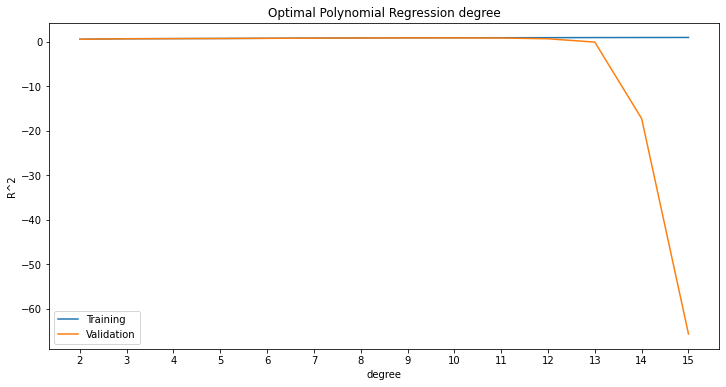

('10', 0.8524361404288741, 0.8234414936702723)

In [20]:
poly_tuning(2,15, 'linear')

Even though R2 is really bad for degrees > 12, degree 10 seems to be the most efficient. 

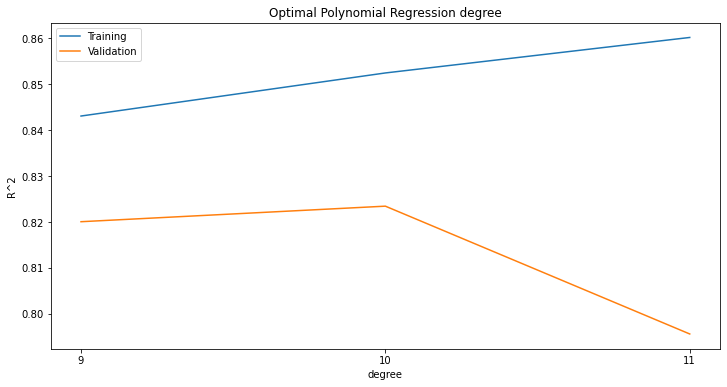

('10', 0.8524361404288741, 0.8234414936702723)

In [21]:
poly_tuning(9,11, 'linear')

In [22]:
effi_deg = poly_tuning(2,15, 'linear', plot = False)
print('Most efficient degree for simple polynomial regression: ' + str(effi_deg[0]) + '; training R2: ' + str(effi_deg[1]) + '; validation R2: ' + str(effi_deg[2]))

Most efficient degree for simple polynomial regression: 10; training R2: 0.8524361404288741; validation R2: 0.8234414936702723


Next we will try to find the optimal degree for Ridge, with alpha 0.1 (since alpha usually is a lot smaller than 1)

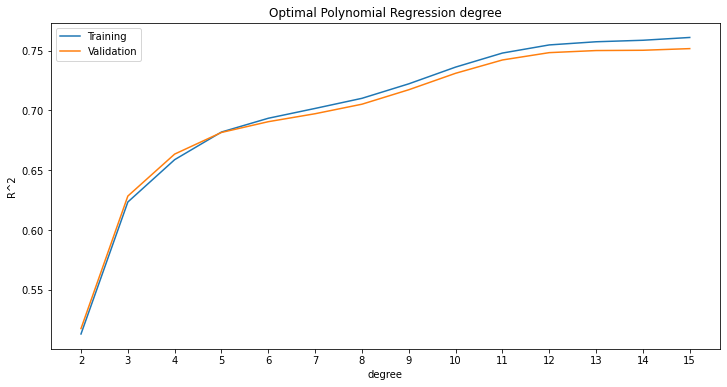

('15', 0.7610441682312903, 0.7517143485353248)

In [23]:
poly_tuning(2,15,'ridge',0.1)

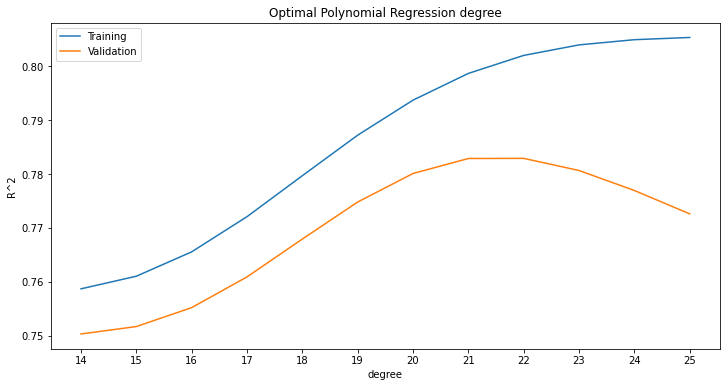

('22', 0.8019720234634221, 0.7828879001780964)

In [24]:
poly_tuning(14,25,'ridge',0.1)

Is this still optimizable? Maybe with an different alpha?

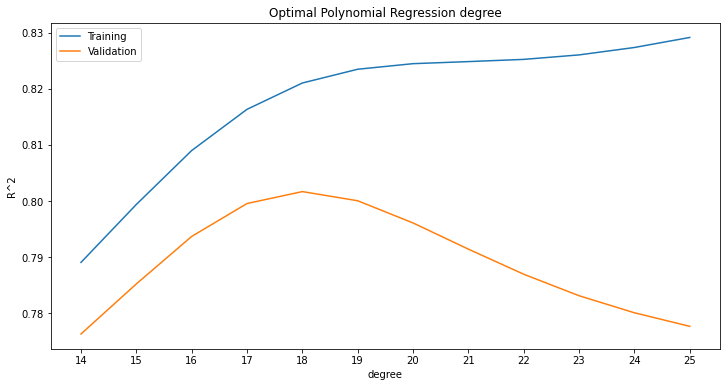

('18', 0.8210393131901286, 0.8016725679957204)

In [25]:
poly_tuning(14,25,'ridge',0.01)

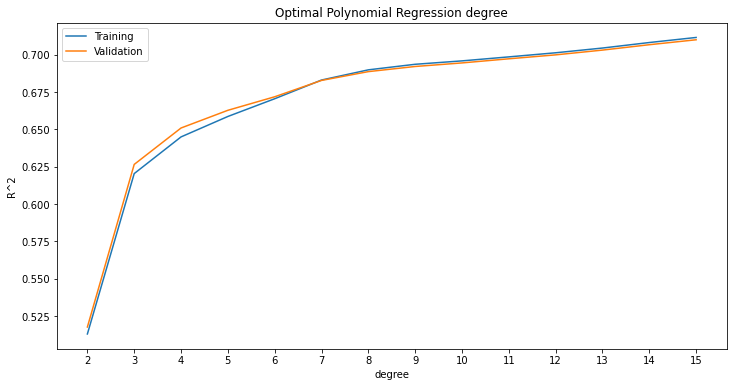

('15', 0.7114634269254851, 0.7099152233995736)

In [26]:
poly_tuning(2,15,'lasso', 0.1)

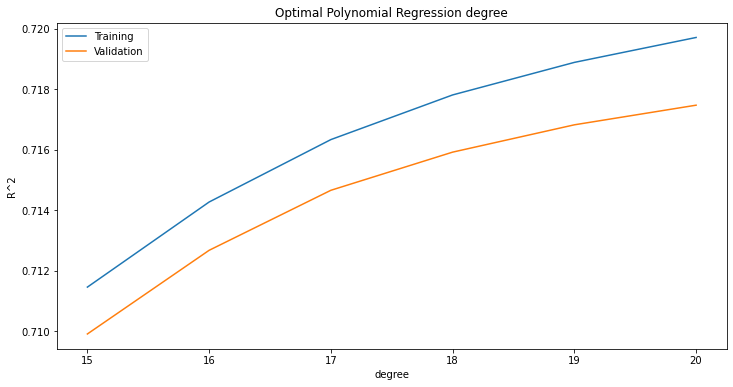

('20', 0.7197114210682617, 0.7174741764527541)

In [27]:
#runtime > 2min 
#output ('20', 0.7197114210682617, 0.7174741764527541)

poly_tuning(15,20,'lasso', 0.1)

Ridge culminated for some degree around 20, which changes depending on the choosen alpha. <br>
Lasso is still continously improving. We should try to optimize the alpha value now, as we can see from the experiment with ridge regression, the degree can change according to the alpha value

This is a function whoch sould calculate an optimal degree and alpha in a given range of degrees and range of alphas. For this it uses the optimal degree function

In [28]:
def regularization_test(alphas_to_try, min_degree, max_degree, 
    Xt_set = X_train, yt_set = y_train, Xv_set = X_validation, 
    yv_set = y_validation, model_name = 'lasso', draw_plot = False):

    Feature_Options = []
    train_scores = []
    validation_scores = []

    for curr_alpha in alphas_to_try:

        results = poly_tuning(min_degree, max_degree, model_name, 
        curr_alpha, Xt_set, yt_set, Xv_set, yv_set, False)

        Feature_Options.append(results[0])
        train_scores.append(results[1])
        validation_scores.append(results[2])

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
            
    if draw_plot:
        rcParams['figure.figsize'] = 12, 6
        plt.plot(alphas_to_try, train_scores)
        plt.plot(alphas_to_try, validation_scores)

        plt.title("Optimal Regularization Parameter for degree " + str(max_degree))
        plt.legend(["Training", "Validation"])
        plt.xlabel("alpha")
        plt.ylabel("R^2")
        plt.show()
    
    return chosen_alpha, Feature_Options[chosen_alpha_id], train_scores[chosen_alpha_id], validation_scores[chosen_alpha_id]

Now we will calculate the optimal regularization parameter for ridge

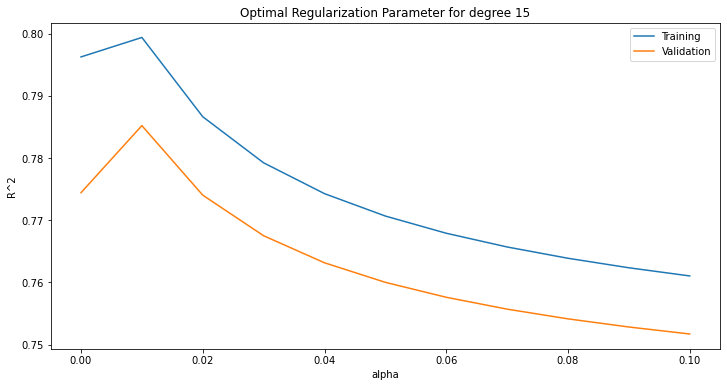

(0.01, '15', 0.799384052631996, 0.7852118887513846)


In [29]:
alphas = np.linspace(0, 0.1, 11)
print(regularization_test(alphas, 2, 15, model_name = 'ridge', draw_plot = True))

After continously optimizing regularization and degree of ridge regessions until no major improvement can be found (not in this notebook, since it would take up a lot of space) we arrived at the following roughly optimal alpha

In [30]:
alphas = []
alphas.append(0.000005)
print(regularization_test(alphas, 12, 12, model_name = 'ridge'))

(5e-06, '12', 0.8471896102346997, 0.8257898365375024)


After this point there were no improvements in 0.0005 R2 Score range, so this will suffice. Optimal Alpha is 0.000005 and degree 12 for ridge regression on this dataset

Now the same thing for Lasso

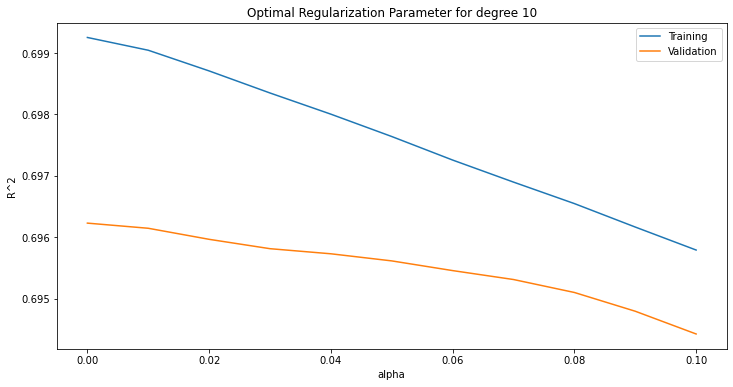

(0.0, '10', 0.699255464314859, 0.6962295417689153)


In [31]:
#runtime > 2min 
#output (0.0, '10', 0.699255464314859, 0.6962295417689153)

alphas = np.linspace(0, 0.1, 11)
print(regularization_test(alphas, 2, 10, model_name = 'lasso', draw_plot = True))

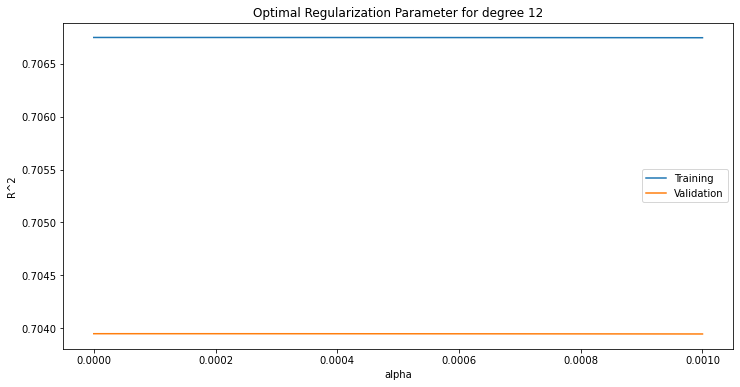

(0.0, '12', 0.7067495000430725, 0.7039483144705022)


In [32]:
#runtime > 4min 
#output (0.0, '12', 0.7067495000430725, 0.7039483144705022)

alphas = np.linspace(0, 0.001, 11)
print(regularization_test(alphas, 9, 12, model_name = 'lasso', draw_plot = True))

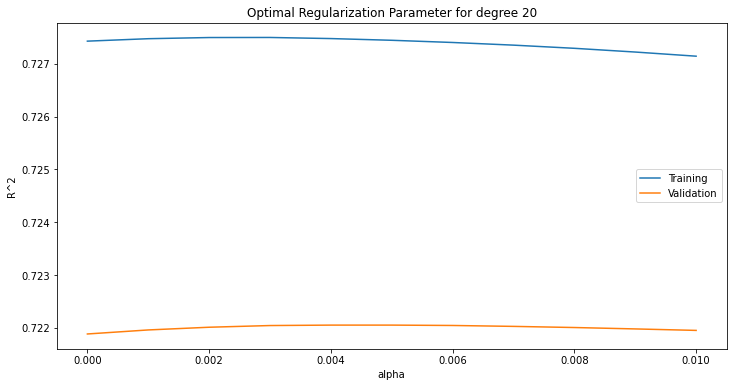

(0.005, '20', 0.7274475978096173, 0.7220505627881275)


In [33]:
#runtime > 9min 
#output (0.001, '20', 0.7274775714193451, 0.7219589602456107)

alphas = np.linspace(0, 0.01, 11)
print(regularization_test(alphas, 20, 20, model_name = 'lasso', draw_plot = True))

It's safe to say that Lasso has a very high computional time, while most likely, even for very small alphas, it will be never able to match the R2 Scores of Ridge, therefore we will not look at it further now <br>
To sum our best Regressions up:

In [34]:
#Polynomial Linear regression
poly = PolynomialFeatures(degree = 10)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_vali_poly = poly.transform(X_validation)
X_vali_poly_scaled = scaler.transform(X_vali_poly)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly_scaled, y_train)
pred = poly_reg.predict(X_vali_poly_scaled)
print("Polynomial linear regression, Degree 10: ")
eval(y_validation, pred)

#Ridge regression
poly = PolynomialFeatures(degree = 12)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_vali_poly = poly.transform(X_validation)
X_vali_poly_scaled = scaler.transform(X_vali_poly)

poly_reg = Ridge(alpha = 0.000005)
poly_reg.fit(X_train_poly_scaled, y_train)
pred = poly_reg.predict(X_vali_poly_scaled)
print("Ridge regression, Degree 12, alpha 0.000005: ")
eval(y_validation, pred)

#Lasso regression
poly = PolynomialFeatures(degree = 20)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_vali_poly = poly.transform(X_validation)
X_vali_poly_scaled = scaler.transform(X_vali_poly)

poly_reg = Lasso(alpha = 0.001)
poly_reg.fit(X_train_poly_scaled, y_train)
pred = poly_reg.predict(X_vali_poly_scaled)
print("Lasso regression, Degree 20, alpha 0.001: ")
eval(y_validation, pred)

Polynomial linear regression, Degree 10: 
MAE: 137.25790589731642
RMSE: 207.19296799502345
R^2: 0.8234414936702723
Ridge regression, Degree 12, alpha 0.000005: 
MAE: 138.69101308444667
RMSE: 205.81045496877414
R^2: 0.8257898365375024
Lasso regression, Degree 20, alpha 0.001: 
MAE: 174.20288261686852
RMSE: 260.00705998444096
R^2: 0.7219589602456107


While we tried every option to optimize the regression tasks for our given data set, we didn't try to change the dataset itself. By changing the time features to dummies we will now try to improve our r2

In [35]:
Copy = hourly_bikesharing_demand.copy()
Copy = pd.get_dummies(Copy, columns=['month'])
Copy = pd.get_dummies(Copy, columns=['hour'])

In [36]:
X2 = Copy[['temp', 'precip', 'weekend', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23']]
y2 = Copy['trips']

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation2, X_test2, y_validation2, y_test2 = train_test_split(X_temp2, y_temp2,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train2)))
print('Size of validation data set: ' + str(len(X_validation2)))
print('Size of test data set: ' + str(len(X_test2)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


In [37]:
poly = PolynomialFeatures(degree = 2)
X_train2_poly = poly.fit_transform(X_train2)

scaler = StandardScaler()
X_train2_poly_scaled = scaler.fit_transform(X_train2_poly) 

X_vali2_poly = poly.transform(X_validation2)
X_vali2_poly_scaled = scaler.transform(X_vali2_poly)

poly_reg = LinearRegression()
poly_reg.fit(X_train2_poly_scaled, y_train2)
pred = poly_reg.predict(X_vali2_poly_scaled)
eval(y_validation2, pred)

MAE: 118.75683809719077
RMSE: 183.9129728290649
R^2: 0.8608883980269818


Right from the start this dataset seems to be way more performative than the anything we have worked on before <br> 
So we now are back at optimzing the degree

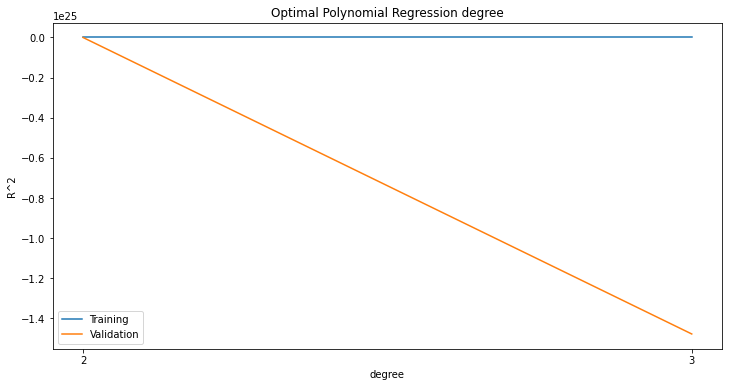

('2', 0.8879240267134632, 0.8608883980269818)

In [38]:
poly_tuning(2, 3, 'linear', Xtrain_set = X_train2, 
    ytrain_set = y_train2, Xvalidation_set = X_validation2, 
    yvalidation_set = y_validation2)

Since degree 3 is already a negative R2, Optimal polynomial degree for linear regression is 2

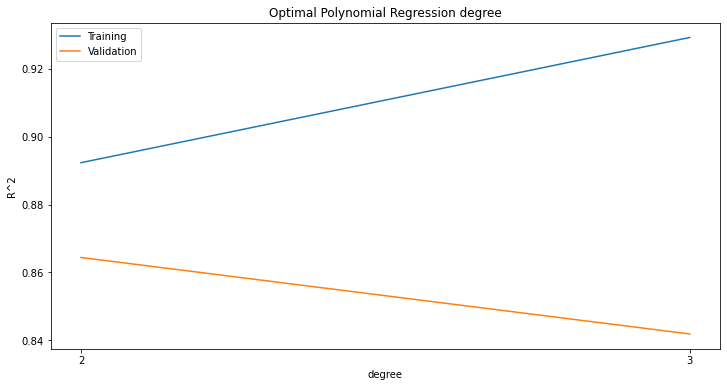

('2', 0.8923459899567459, 0.8643987477010301)

In [39]:
poly_tuning(2, 3, 'ridge', alpha = 0.1, Xtrain_set = X_train2, 
    ytrain_set = y_train2, Xvalidation_set = X_validation2, 
    yvalidation_set = y_validation2)

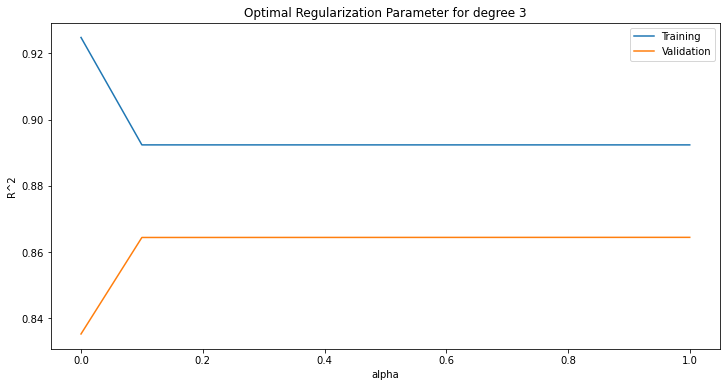

(1.0, '2', 0.8923455015353723, 0.8644363187092006)


In [40]:
alphas = np.linspace(0, 1, 11)
print(regularization_test(alphas, 2, 3, model_name = 'ridge', Xt_set = X_train2, 
    yt_set = y_train2, Xv_set = X_validation2, 
    yv_set = y_validation2, draw_plot = True))

Optimized alpha and degree through iterative executions

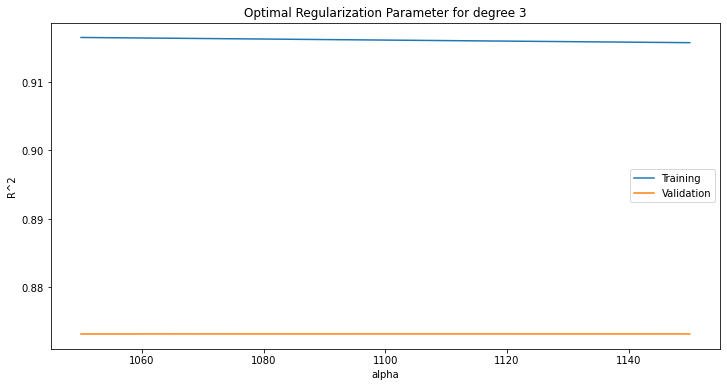

(1110.0, '3', 0.9160377873079062, 0.8732158182396325)


In [41]:
alphas = np.linspace(1050, 1150, 11)
print(regularization_test(alphas, 2, 3, model_name = 'ridge', Xt_set = X_train2, 
    yt_set = y_train2, Xv_set = X_validation2, 
    yv_set = y_validation2, draw_plot = True))

Next we will optimize Lasso for the dummy dataset

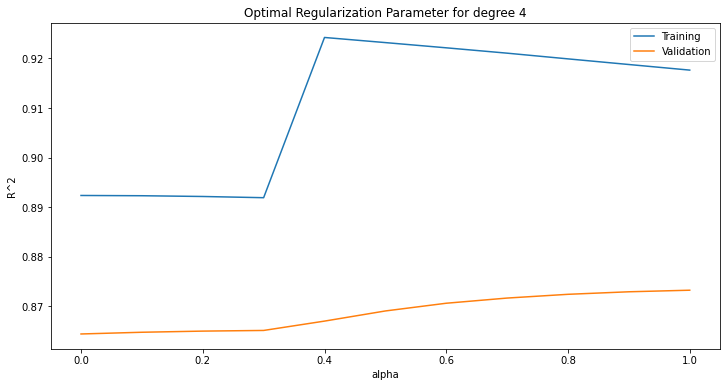

(1.0, '3', 0.9176462435974313, 0.8732271873879942)


In [42]:
#runtime > 10min 
#output (1.0, '3', 0.9176462435974313, 0.8732271873879942)

alphas = np.linspace(0, 1, 11)
print(regularization_test(alphas, 2, 4, model_name = 'lasso', Xt_set = X_train2, 
    yt_set = y_train2, Xv_set = X_validation2, 
    yv_set = y_validation2, draw_plot = True))

After iterative optimizing

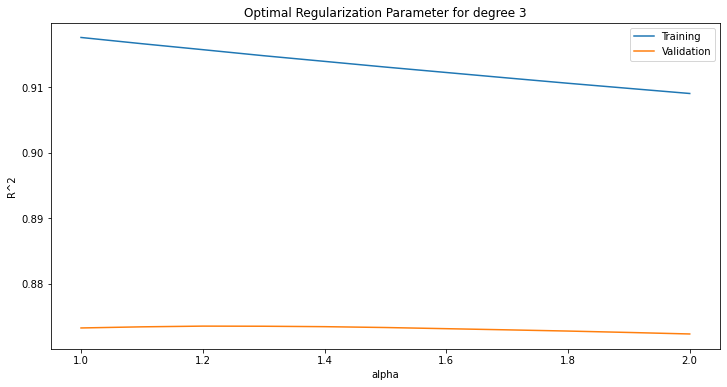

(1.2, '3', 0.9157815565677199, 0.873507778835803)


In [43]:
#runtime > 1min 
#output (1.2, '3', 0.9157815565677199, 0.873507778835803)

alphas = np.linspace(1, 2, 11)
print(regularization_test(alphas, 2, 3, model_name = 'lasso', Xt_set = X_train2, 
    yt_set = y_train2, Xv_set = X_validation2, 
    yv_set = y_validation2, draw_plot = True))

## Model Evaluation

How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment?

It seems, after all, the Ridge & Lasso Regression on the second dataset have the highest performace of close to 87,4% R2 Score on the validation set. Lets look at their MSE to see if it improved

In [44]:
# Ridge (1110.0, '3', 0.9160377873079062, 0.8732158182396325)
poly = PolynomialFeatures(degree = 3)
X_train2_poly = poly.fit_transform(X_train2)

scaler = StandardScaler()
X_train2_poly_scaled = scaler.fit_transform(X_train2_poly) 

X_vali2_poly = poly.transform(X_validation2)
X_vali2_poly_scaled = scaler.transform(X_vali2_poly)

poly_reg = Ridge(alpha = 1110)
poly_reg.fit(X_train2_poly_scaled, y_train2)
pred = poly_reg.predict(X_vali2_poly_scaled)
print("Performance of Ridge with degree 3 and alpha 1110:")
eval(y_validation2, pred)

Performance of Ridge with degree 3 and alpha 1110:
MAE: 100.62907258323023
RMSE: 175.57522137059598
R^2: 0.8732158182396325


In [45]:
#Lasso (1.2, '3', 0.9157815565677199, 0.873507778835803)
poly = PolynomialFeatures(degree = 3)
X_train2_poly = poly.fit_transform(X_train2)

scaler = StandardScaler()
X_train2_poly_scaled = scaler.fit_transform(X_train2_poly) 

X_vali2_poly = poly.transform(X_validation2)
X_vali2_poly_scaled = scaler.transform(X_vali2_poly)

poly_reg = Lasso(alpha = 1.2)
poly_reg.fit(X_train2_poly_scaled, y_train2)
pred = poly_reg.predict(X_vali2_poly_scaled)
print("Performance of Lasso with degree 3 and alpha 1,2:")
eval(y_validation2, pred)

Performance of Lasso with degree 3 and alpha 1,2:
MAE: 102.04730152797056
RMSE: 175.3729461703103
R^2: 0.873507778835803


Since our MAE and RMSE also decreased dramatically, we will call this an success

### Test set

We will now test the best performing and optimizied algorithm of dataset2 on the test split and compare it with the performace of the the best algorithm of the first dataset on the test set

In [46]:
#Markdown = beide algorythmen, erst für dataset 2
#Ridge
poly = PolynomialFeatures(degree = 3)
X_train2_poly = poly.fit_transform(X_train2)

scaler = StandardScaler()
X_train2_poly_scaled = scaler.fit_transform(X_train2_poly) 

X_test2_poly = poly.transform(X_test2)
X_test2_poly_scaled = scaler.transform(X_test2_poly)

poly_reg = Ridge(alpha = 1110)
poly_reg.fit(X_train2_poly_scaled, y_train2)
pred = poly_reg.predict(X_test2_poly_scaled)
print("Performance of Ridge with degree 3 and alpha 1110:")
eval(y_test2, pred)
#Lasso
poly = PolynomialFeatures(degree = 3)
X_train2_poly = poly.fit_transform(X_train2)

scaler = StandardScaler()
X_train2_poly_scaled = scaler.fit_transform(X_train2_poly) 

X_test2_poly = poly.transform(X_test2)
X_test2_poly_scaled = scaler.transform(X_test2_poly)

poly_reg = Lasso(alpha = 1.2)
poly_reg.fit(X_train2_poly_scaled, y_train2)
pred = poly_reg.predict(X_test2_poly_scaled)
print("Performance of Lasso with degree 3 and alpha 1,2:")
eval(y_test2, pred)

Performance of Ridge with degree 3 and alpha 1110:
MAE: 96.17864610136465
RMSE: 165.95483370807173
R^2: 0.893080067488209
Performance of Lasso with degree 3 and alpha 1,2:
MAE: 96.96610979456521
RMSE: 165.89739382936787
R^2: 0.8931540684074039


An R^2 Score of close to 90 is a very optimal result compared to where we started. We even managed to reduce our MAE under 100 and also reduce RMSE by an high amount.

As an comparison the performance of the best performing algorithm on dataset 1

In [47]:
poly = PolynomialFeatures(degree = 12)
X_train_poly = poly.fit_transform(X_train)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly) 

X_test_poly = poly.transform(X_test)
X_test_poly_scaled = scaler.transform(X_test_poly)

poly_reg = Ridge(alpha = 0.000005)
poly_reg.fit(X_train_poly_scaled, y_train)
pred = poly_reg.predict(X_test_poly_scaled)
print("Ridge regression, Degree 12, alpha 0.000005: ")
eval(y_test, pred)

Ridge regression, Degree 12, alpha 0.000005: 
MAE: 133.46920000454733
RMSE: 201.8880772193021
R^2: 0.841765854286746


Concluding: The best performing algorithm are both on the second dataset and have a much lower degree. With R^2 Scores close to 90 they perform very well for ML algorithms on a dataset with as much variance as this one

## Outlook

This will be done in the Report